# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
np.random.seed(42)

In [6]:
YEAR = 252
idx = pd.IndexSlice

In [7]:
DATA_DIR = Path('..', 'data')

In [8]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

See the notebook [korea_equity_features](03_korea_equity_features.ipynb) in this directory for data preparation.

In [9]:
data = pd.read_hdf('data.h5', 'finance_datareader/korea/equities')
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 974070 entries, ('000020', Timestamp('2010-01-04 00:00:00')) to ('114090', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ret_1            973675 non-null  float64
 1   ret_rel_perc_1   973675 non-null  float64
 2   ret_5            972095 non-null  float64
 3   ret_rel_perc_5   972095 non-null  float64
 4   ret_10           970120 non-null  float64
 5   ret_rel_perc_10  970120 non-null  float64
 6   ret_21           965775 non-null  float64
 7   ret_rel_perc_21  965775 non-null  float64
 8   ret_63           949185 non-null  float64
 9   ret_rel_perc_63  949185 non-null  float64
 10  PPO              964195 non-null  float64
 11  NATR             968540 non-null  float64
 12  RSI              968540 non-null  float64
 13  bbl              972490 non-null  float64
 14  bbu              972490 non-null  float64
 15  week

We start with 941 tickers.

In [10]:
len(data.index.unique('ticker'))

395

### Select universe of 250 most-liquid stocks

We rank the stocks by their daily average dollar volume and select those with the 250 lowest average ranks and thus highest average volumes for the 2010-2017 period.

In [11]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'finance_datareader/prices')
          .loc[idx['2010': '2017', :], :]
          .filter(like='adj_')
          .rename(columns=lambda x: x.replace('adj_', ''))
         )

In [12]:
dollar_vol = prices.close.mul(prices.volume)
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='ticker').mean().nsmallest(250).index

## MultipleTimeSeriesCV

See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [13]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

For each fold, the train and test periods are separated by a `lookahead` number of periods and thus do not overlap:

In [14]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    if i == 3:
        break

Training: 2017-10-30-2019-11-22  (508 days) | Test: 2019-11-29-2019-12-30 (21 days)
Training: 2017-09-21-2019-10-24  (508 days) | Test: 2019-10-31-2019-11-28 (21 days)
Training: 2017-08-23-2019-09-23  (508 days) | Test: 2019-09-30-2019-10-30 (21 days)
Training: 2017-07-24-2019-08-21  (508 days) | Test: 2019-08-28-2019-09-27 (21 days)


## Model Selection: Time Period and Horizon

For the model selection step, we restrict training and validation sets to the 2010-2017 period.

In [15]:
cv_data = data.loc[idx[universe, :'2017'], :]
tickers = cv_data.index.unique('ticker')

Persist the data to save some time when running another experiment:

In [16]:
cv_data.to_hdf('data.h5', 'finance_datareader/korea/equities/cv_data')

In [17]:
with pd.HDFStore('data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/finance_datareader/korea/equities                    frame        (shape->[974070,23]) 
/finance_datareader/korea/equities/cv_data            frame        (shape->[260832,23]) 
/kr/equities/monthly                                  frame        (shape->[82611,30])  
/kr/equities/prices                                   frame        (shape->[2771533,19])
/us/equities/monthly                                  frame        (shape->[82611,30])  
/us/equities/prices                                   frame        (shape->[2771533,19])


We're picking prediction horizons of 1, 5, 10 and 21 days:

In [18]:
lookaheads = [1, 5, 10, 21]
# 횟수 줄이기
# lookaheads = [1]

## Baseline: Linear Regression

Since it's quick to run and quite informative, we generate linear regression baseline predictions. See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [19]:
lr = LinearRegression()

In [20]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

### CV Parameters

We set five different training lengths from 3 months to 5 years, and two test periods as follows:

In [21]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
# train_lengths = [63]
# test_lengths = [5]

Since linear regression has no hyperparameters, our CV parameters are the cartesian product of prediction horizon and train/test period lengths:

In [22]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

Now we iterate over these parameters and train/validate the linear regression model while capturing the information coefficient of the model predictions, measure both on a daily basis and for each complete fold:

In [23]:
lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:24<00:00,  2.12s/it]


In [24]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


### Information Coefficient distribution by Lookahead

Convert the data to long `seaborn`-friendly format:

In [25]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB


Plot both IC measures for the various CV parameters:

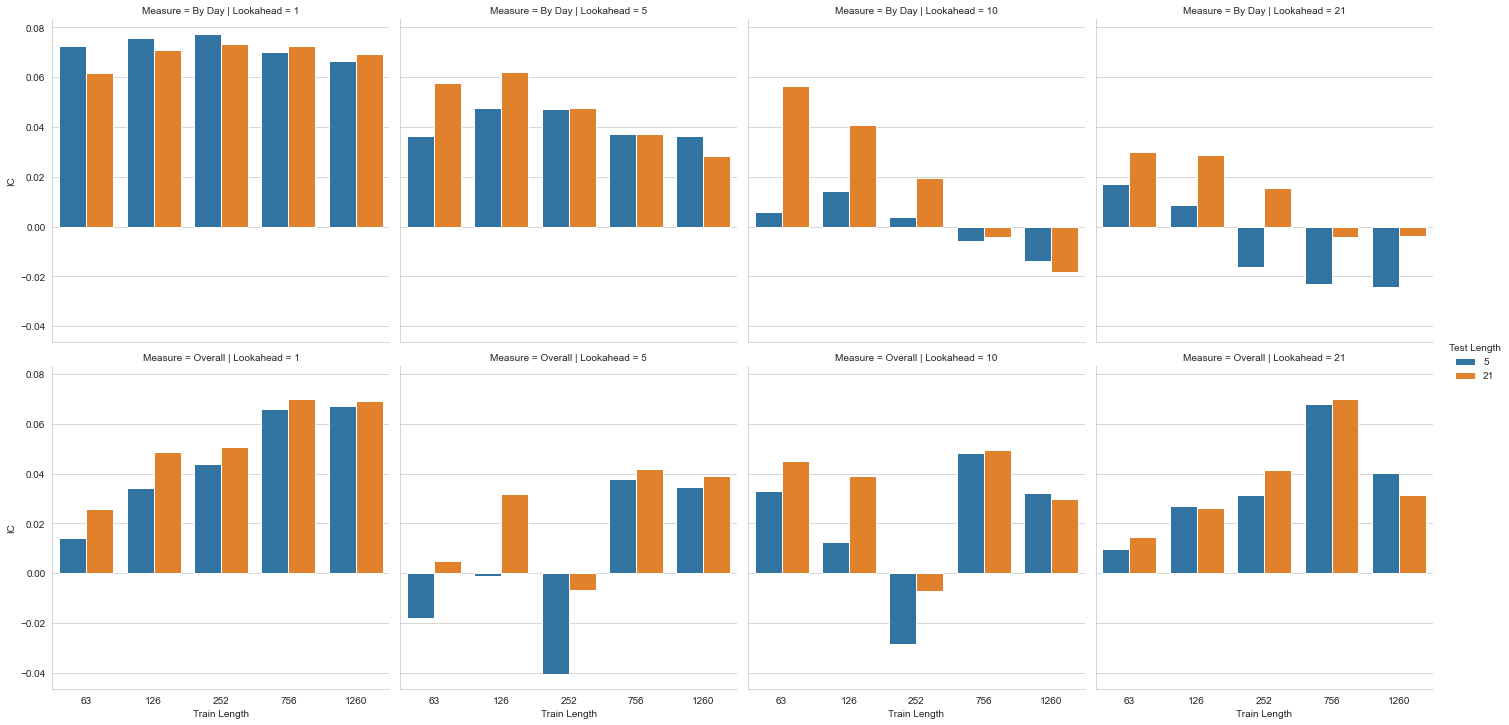

In [26]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

Compare the distributions of each IC metric for the different prediction horizons:

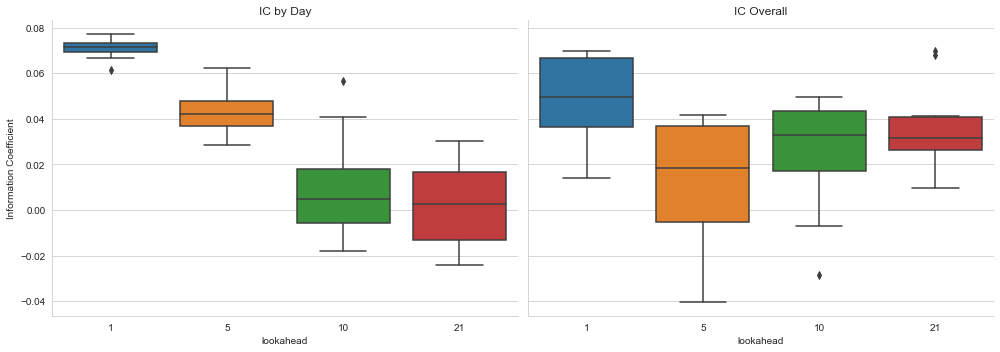

In [27]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

### Best Train/Test Period Lengths

Show the best train/test period settings for the four prediction horizons:

In [28]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
3,1,756,21,0.072366,0.069873
1,1,1260,21,0.069236,0.069232
0,1,1260,5,0.066478,0.067078
13,5,756,21,0.037210,0.041696
11,5,1260,21,0.028420,0.039056
12,5,756,5,0.037189,0.037738
23,10,756,21,-0.004322,0.049533
22,10,756,5,-0.005968,0.048216
29,10,63,21,0.056593,0.044831
33,21,756,21,-0.004087,0.069927


In [29]:
lr_metrics.to_csv(results_path / 'lin_reg_performance.csv', index=False)

## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

In [30]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

LightGBM base parameter settings that are independent of hyperparameter tuning:

In [31]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

### Hyperparameter Options

We run this experiment with different parameters for the bagging and feature fractions that determine the degree of randomization as well as the minimum number of samples for a split to control overfitting:

In [32]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [250, 500, 1000]
# bagging_fraction_opts = [.5]
# feature_fraction_opts = [.75]
# min_data_in_leaf_opts = [250]

This gives us 3x2x3=18 parameter combinations:

In [33]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

#### Random Sample

To limit the running time, we can randomly sample a subset of the parameter combinations (here: 50%):

In [34]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9


We tune the number of trees by evaluating a fully grown forest for various smaller sizes:

In [35]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

### Train/Test Period Lenghts

As above for linear regression, we define a range of train/test period length:

#### Define parameters

In [36]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [37]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

#### Random sample

Just as for the model parameters, we can randomly sample from the 5 x 2 = 8 training configurations (here: 50%):

In [38]:
sample_proportion = 1.0
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 10
CV Iterations: 90


In [39]:
# 간소화 
test_params_ = [test_params_[0], test_params_[1]]

### Categorical Variables

To leverage LightGBM's ability to handle categorical variables, we need to define them; we'll also `factorize` them so they are both integer-encoded and start at zero (optional, but otherwise throws a warning) as expected by LightGBM:

In [40]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Run Cross-Validation

Set up some helper variabels and storage locations to faciliate the CV process and result storage:

In [41]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [42]:
label_dict = dict(zip(lookaheads, labels))

In [43]:
cv_store = Path(results_path / 'parameter_tuning.h5')

In [44]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [45]:
for lookahead in lookaheads:
    for train_length, test_length in test_params_:
        n_splits = int(2 * YEAR / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                lgb_train = lgb_data.subset(train_idx.tolist(), params=params).construct()
                lgb_test = lgb_data.subset(test_idx.tolist(), params=params).construct()

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)

        m = pd.DataFrame(ic, columns=ic_cols)
        m.to_hdf(cv_store, 'ic/' + key)
        pd.concat(daily_ic).to_hdf(cv_store, 'daily_ic/' + key)
        pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
        pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

Lookahead:  1 | Train:  63 | Test: 21 | Params:   9
  0 | 00:00:27 | 50% | 75% |   250 |  2.13% |  2.83% |  3.06%
  1 | 00:00:50 | 50% | 75% |   500 |  1.77% |  2.82% |  3.37%
  2 | 00:01:11 | 75% | 75% | 1,000 |  1.81% |  2.80% |  3.18%
  3 | 00:01:30 | 50% | 95% | 1,000 |  2.33% |  2.97% |  3.86%
  4 | 00:01:57 | 50% | 95% |   250 |  2.04% |  2.51% |  3.28%
  5 | 00:02:24 | 95% | 75% |   500 |  1.92% |  2.43% |  2.81%
  6 | 00:02:52 | 95% | 95% |   500 |  2.03% |  1.98% |  2.93%
  7 | 00:03:19 | 95% | 95% |   250 |  2.01% |  2.11% |  2.06%
  8 | 00:03:40 | 75% | 95% | 1,000 |  1.63% |  2.31% |  2.66%
Lookahead:  1 | Train: 756 | Test:  5 | Params:   9
  0 | 00:04:25 | 50% | 75% |   250 |  5.76% |  4.78% |  4.72%
  1 | 00:08:59 | 50% | 75% |   500 |  5.47% |  5.03% |  4.63%
  2 | 00:12:56 | 75% | 75% | 1,000 |  5.61% |  4.79% |  4.65%
  3 | 00:17:24 | 50% | 95% | 1,000 |  4.63% |  4.32% |  4.22%
  4 | 00:21:38 | 50% | 95% |   250 |  5.08% |  4.17% |  4.03%
  5 | 00:25:31 | 95% | 75% |

## Analyse Cross-Validation Results

### Collect Data

We'll now combine the CV results that we stored separately for each fold (to avoid loosing results in case something goes wrong along the way):

In [46]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

We'll look at the financial performance in the notebook `alphalens_signal_quality`.

In [47]:
daily_ic, ic = [], []
for t in lookaheads:
    print(t)
    with pd.HDFStore(cv_store) as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            print(train_length, test_length)
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t,
                    'train_length': int(train_length),
                    'test_length': int(test_length)}

            ic.append(pd.melt(store['ic/' + k]
                              .assign(**cols),
                              id_vars=id_vars[:-1],
                              value_name='ic',
                              var_name='rounds')
                      .apply(pd.to_numeric))

            df = store['daily_ic/' + k].assign(**cols).reset_index()
            daily_ic.append(pd.melt(df,
                                    id_vars=id_vars,
                                    value_name='daily_ic',
                                    var_name='rounds')
                            .set_index('date')
                            .apply(pd.to_numeric)
                            .reset_index())            
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

1
756 5
63 21
756 5
63 21
5
756 5
63 21
10
756 5
63 21
21
756 5
63 21


### Predictive Performance: CV Information Coefficient by Day

We first look at the daily IC, the metric we ultimately care about for a daily trading strategy. The best results for all prediction horizons are typically achieved with three years of training; the shorter horizons work better with 21 day testing period length. More regularization often improves the result but the impact of the bagging and feature fraction parameters are a little less clear cut and likely depend on other parameters.

In [48]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
205,1,756,5,0.50,0.75,500,150,0.050290
206,1,756,5,0.50,0.75,500,175,0.050099
203,1,756,5,0.50,0.75,500,100,0.049927
628,5,756,5,0.75,0.75,1000,225,0.034754
624,5,756,5,0.75,0.75,1000,125,0.034581
629,5,756,5,0.75,0.75,1000,250,0.034504
921,10,756,5,0.50,0.75,500,50,0.023616
1031,10,756,5,0.95,0.75,500,300,0.023460
934,10,756,5,0.50,0.75,500,375,0.023334
1342,21,756,5,0.75,0.75,1000,75,0.049267


In [49]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 1440 non-null   int64  
 1   train_length      1440 non-null   int64  
 2   test_length       1440 non-null   int64  
 3   bagging_fraction  1440 non-null   float64
 4   feature_fraction  1440 non-null   float64
 5   min_data_in_leaf  1440 non-null   int64  
 6   rounds            1440 non-null   int64  
 7   ic                1440 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 90.1 KB


For a 1-day forecast horizon, over 75% of the predictions yield a positive daily IC; the same is true for 21 days which, unsurprisingly, also shows a wider range.

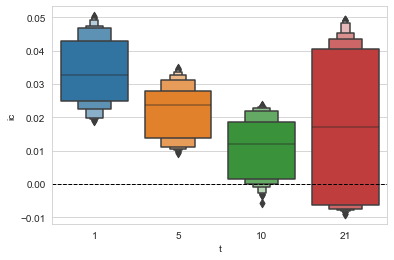

In [50]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

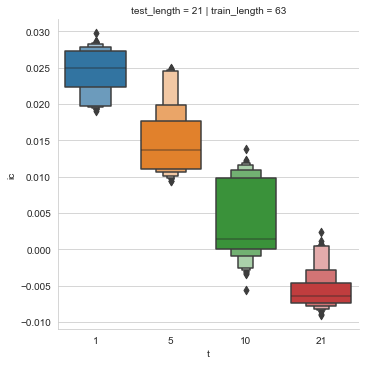

In [51]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == 21)],
                kind='boxen')
g.savefig(results_path / 'daily_ic_test_21', dpi=300);

### HyperParameter Impact: Linear Regression

To get a better idea of how the various CV parameters impact the forecast quality, we can run a linear regression with the daily IC as outcome and the one-hot encoded hyperparameters as inputs:

In [52]:
lin_reg = {}
for t in [1, 5]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    print(X)
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(results_path / f'lr_result_{t:02}.csv', index=False)

     const  train_length_756  test_length_21  bagging_fraction_0.75  \
0      1.0                 0               1                      0   
1      1.0                 0               1                      0   
2      1.0                 0               1                      0   
3      1.0                 0               1                      0   
4      1.0                 0               1                      0   
..     ...               ...             ...                    ...   
345    1.0                 1               0                      0   
346    1.0                 1               0                      0   
347    1.0                 1               0                      0   
348    1.0                 1               0                      0   
349    1.0                 1               0                      0   

     bagging_fraction_0.95  feature_fraction_0.95  min_data_in_leaf_500  \
0                        0                      0                     0 

In [53]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Train\nLength', xy=(.09, -0.1), xytext=(.09, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Test\nLength', xy=(.23, -0.1), xytext=(.23, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Bagging\nFraction', xy=(.32, -0.1), xytext=(.32, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.7, lengthB=0.8', lw=1.0, color='black'))


    ax.annotate('Feature\nFraction', xy=(.44, -0.1), xytext=(.44, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=3.4, lengthB=1.0', lw=1.0, color='black'))
    

    ax.annotate('Min.\nSamples', xy=(.55, -0.1), xytext=(.55, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.0', lw=1.0, color='black'))    
    
    ax.annotate('Number of\nRounds', xy=(.8, -0.1), xytext=(.8, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=1.0', lw=1.0, color='black'))

The below plot shows the regression coefficient values and their confidence intervals. The intercept (not shown) has a small positive value and is statistically signifant; it captures the impact of the dropped categories (the smallest value for each parameter).

For 1-day forecasts, some but not all results are insightful: 21-day testing is better, and so is `min_samples_leaf` of 500 or 1,000. 100-200 trees seem to work best, but both shorter and longer training periods are better than intermediate values.

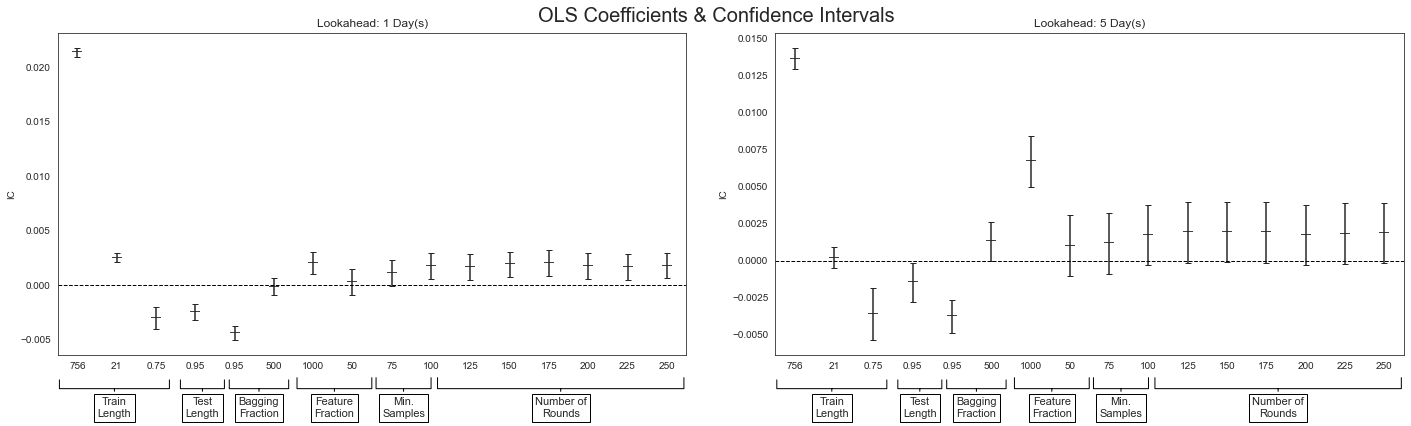

In [54]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes = axes.flatten()
    for i, t in enumerate([1, 5]):
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.92)

### Information Coefficient: Overall

We'll also take a look at the overall IC value, which is often reported but does not necessarily match the goal of a daily trading strategy that uses the model return predictions as well as the daily IC.

In [55]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      1800 non-null   int64  
 1   test_length       1800 non-null   int64  
 2   bagging_fraction  1800 non-null   float64
 3   feature_fraction  1800 non-null   float64
 4   min_data_in_leaf  1800 non-null   int64  
 5   t                 1800 non-null   int64  
 6   rounds            1800 non-null   int64  
 7   ic                1800 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 112.6 KB


#### Best Parameters

Directionally, and for shorter periods, similar hyperparameter settings work best (while the IC values are higher):

In [56]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                        
1  99             756            5              0.50              0.75   
   459            756            5              0.50              0.75   
   32             756            5              0.95              0.75   
5  724            756            5              0.50              0.95   
   744            756            5              0.95              0.95   
   762            756            5              0.95              0.95   
10 1210           756            5              0.50              0.95   
   1219           756            5              0.50              0.95   
   1201           756            5              0.50              0.95   
21 1627            63           21              0.95              0.95   
   1636            63           21              0.95              0.95   
   1626            63           21              0.95              0.95   

         min_data_in_leaf   t  rounds        ic  
t                                                
1  99                 250   1     300  0.057570  
   459                250   1     300  0.057570  
   32                 500   1     100  0.057568  
5  724                250   5      25  0.072715  
   744                500   5      75  0.069562  
   762                500   5     125  0.069515  
10 1210               250  10     375 -0.002840  
   1219               250  10     400 -0.002900  
   1201               250  10     350 -0.002923  
21 1627               250  21      25  0.013403  
   1636               250  21      50  0.012121  
   1626               500  21      25  0.011610

#### Visualiztion

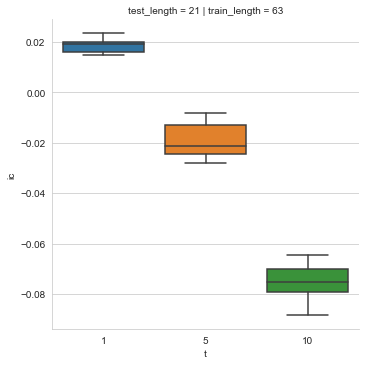

In [57]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)],
                kind='box')

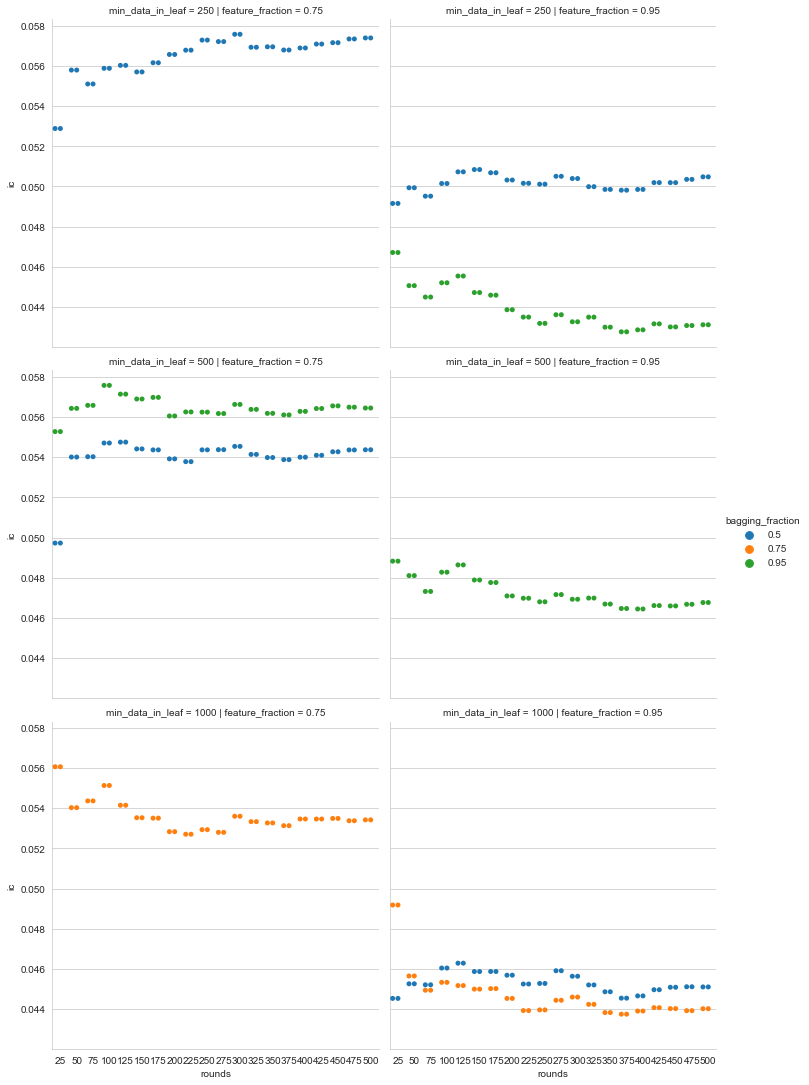

In [67]:
t = 1
train_length = 756
test_length = 5
g = sns.catplot(x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm');

### Random Forest vs Linear Regression 

Let's compare the best-performing (in-sample) random forest models to our linear regression baseline:

In [68]:
lr_metrics = pd.read_csv(results_path / 'lin_reg_performance.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


In [69]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 1440 non-null   int64  
 1   train_length      1440 non-null   int64  
 2   test_length       1440 non-null   int64  
 3   bagging_fraction  1440 non-null   float64
 4   feature_fraction  1440 non-null   float64
 5   min_data_in_leaf  1440 non-null   int64  
 6   rounds            1440 non-null   int64  
 7   ic                1440 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 90.1 KB


The results are mixed: for the shortest and longest horizons, the random forest outperforms (slightly for 1 day), while linear regression is competitive for the intermediate horizons:

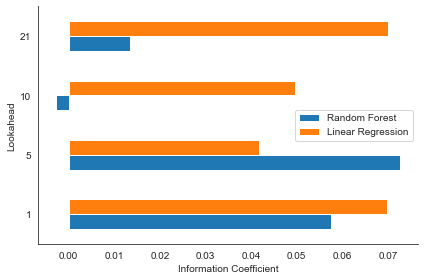

In [70]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();

## Generate predictions

To build and evaluate a trading strategy, we create predictions for the 2018-19 period using the 10 best models that we then ensemble:

In [71]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

In [72]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [73]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

store = Path(results_path / 'predictions.h5')

In [74]:
for lookahead in [1, 5, 10, 21]:
    if lookahead > 1: 
        continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_hdf('data.h5', 'finance_datareader/korea/equities'))
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(10):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(2 * YEAR / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        params=params).construct()
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)

            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(10):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_hdf(store, f'test/{lookahead:02}')


Lookahead: 01
	Position: 00
	Position: 01
	Position: 02
	Position: 03
	Position: 04
	Position: 05
	Position: 06
	Position: 07
	Position: 08
	Position: 09
